#Lib

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import imageio

# Plot image

In [26]:
def plot_img(img, size=(7,7), title=""):
    cmap = "gray" if len(img.shape) == 2 else None
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

In [27]:
def plot_imgs(imgs, cols=5, size=7, title=""):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        cmap="gray" if len(img.shape) == 2 else None
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

<ipython-input-80-3618bc6620a8>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  src_img = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
<ipython-input-80-3618bc6620a8>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tar_img = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')


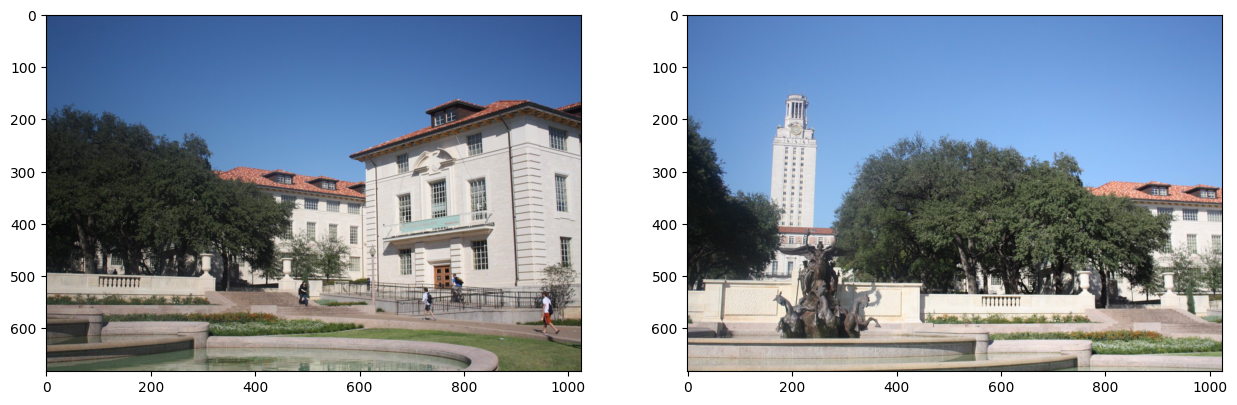

In [80]:
src_img = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
tar_img = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')

src_gray = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
tar_gray = cv2.cvtColor(tar_img, cv2.COLOR_RGB2GRAY)

plot_imgs([src_img, tar_img], size=8)

In [81]:
src_img.shape

(683, 1024, 3)

In [82]:
tar_img.shape

(683, 1024, 3)

#SIFT detector - find keypoints

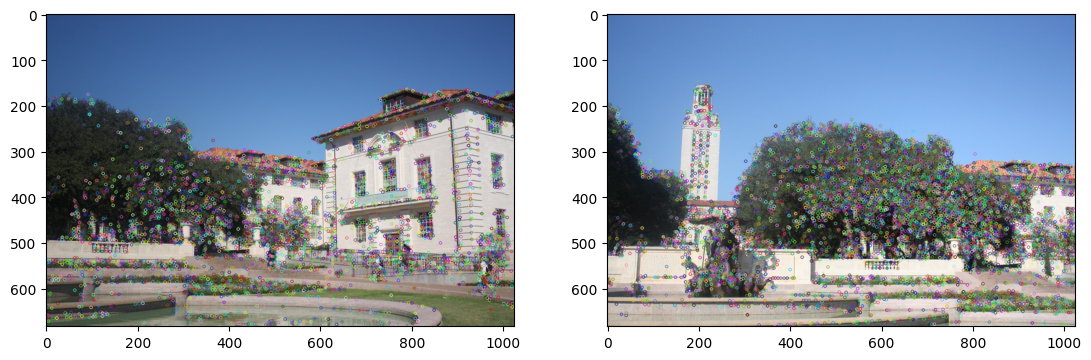

In [83]:
SIFT_detector = cv2.xfeatures2d.SIFT_create()
kp1, des1 = SIFT_detector.detectAndCompute(src_gray, None)
kp2, des2 = SIFT_detector.detectAndCompute(tar_gray, None)

plot_imgs([
    cv2.drawKeypoints(src_img, kp1, None),
    cv2.drawKeypoints(tar_img, kp2, None)
])

#Match keypoint

Bruce Force KNN trả về list k ứng viên cho mỗi keypoint.

In [84]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

rawMatches = bf.knnMatch(des1, des2, 2)
matches = []
ratio = 0.75

for m, n in rawMatches:
    # giữ lại các cặp keypoint sao cho với kp1, khoảng cách giữa kp1 với ứng viên 1 nhỏ hơn nhiều so với khoảng cách giữa kp1 và ứng viên 2
    if m.distance < n.distance * 0.75:
        matches.append(m)

Do có cả nghìn match keypoint, ta chỉ lấy tầm 100 -> 200 cặp tốt nhất để tốc độ xử lí nhanh hơn

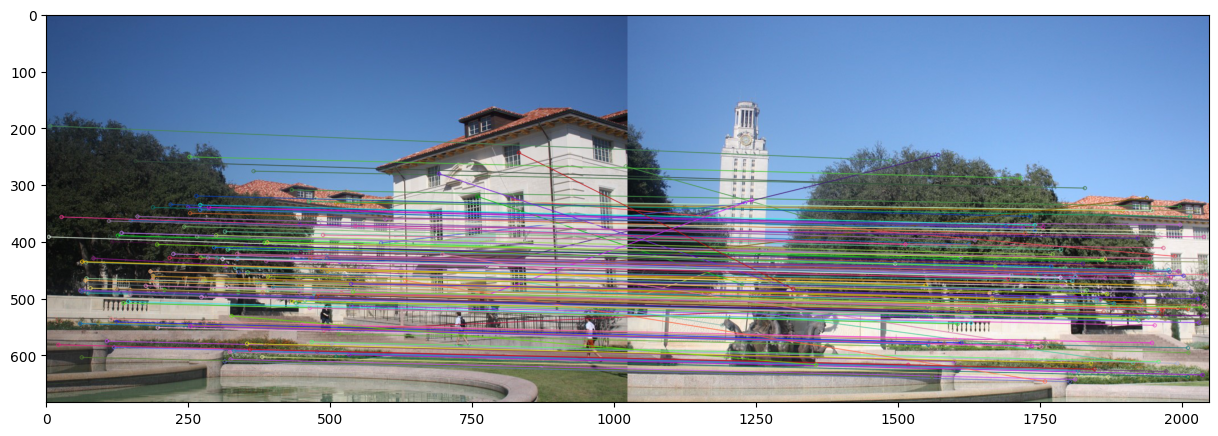

In [85]:
matches = sorted(matches, key=lambda x: x.distance, reverse=True)
matches = matches[:200]

img3 = cv2.drawMatches(src_img, kp1, tar_img, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plot_img(img3, size=(15, 10))

#Estimate Homography matrix and Transform Image

In [86]:
kp1 = np.float32([kp.pt for kp in kp1])
kp2 = np.float32([kp.pt for kp in kp2])

pts1 = np.float32([kp1[m.queryIdx] for m in matches])
pts2 = np.float32([kp2[m.trainIdx] for m in matches])

# estimate the homography between the sets of points
(H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC)
print(H)

[[ 7.75666982e-01  3.11120825e-02  4.48405877e+02]
 [-1.31686384e-01  9.12501023e-01  7.60397062e+01]
 [-2.03218775e-04 -3.12560050e-05  1.00000000e+00]]


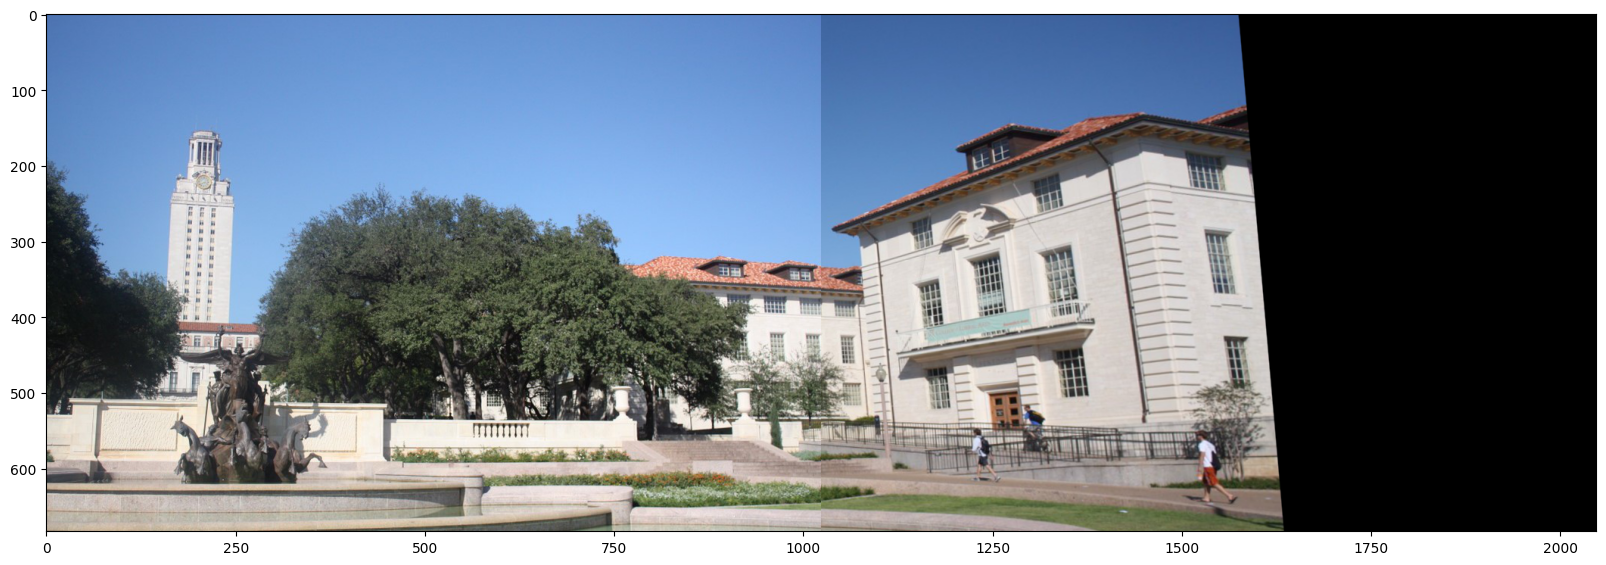

In [87]:
h1, w1 = src_img.shape[:2]
h2, w2 = tar_img.shape[:2]

result = cv2.warpPerspective(src_img, H, (w1+w2, h1))
result[0:h2, 0:w2] = tar_img

plot_img(result, size=(20,10))